# HYSPLIT Modeling V3

This notebook represents the second version of the HYSPLIT modeling scripts. Currently in use are several functions within a related package called hypy.py. Please make sure to have this python file in the working directory of this notebook alongside a working installation of HYSPLIT and related NARR files.

Checklist: 
1. Only run simulations on unique chemical, location, combinations. - DONE
2. Figure out what this bug is that is causing some of the windows to not have data available {TODO}
3. See if it's possible to parallel the code//see how much faster it is on linux. - WORKING ON BRENT
4. Figure out a way to bring all the data onto the server. - WORKING ON BRENT
5. Concatenation of output file from shapes into grid. Merge together outputs

In [37]:
#Libraries Utilized: 
#USE Lab env!
#%load_ext autoreload
%autoreload 2

#Basic py: 
import numpy as np
import pandas as pd
import datetime
import os
import glob
import shutil
from pathlib import Path

#Vis
import matplotlib.pyplot as plt

#Geo
import geopandas as gpd
import fiona
from shapely.geometry import Point
import descartes
import contextily as ctx #Basemaps 
import rtree

#Custom Functions:
from hypy import HYSPLIT_configure, RSEI_merger_2,RSEI_merger, hysplit_input_conversion, chem_date_comb,chem_date_comb_2,uniq_fac_calc

## Preprocess the TRI Data

In [2]:
#Load the Data
tri_df = pd.read_csv('TRI_Carc_FSRel_9099.csv').drop(columns =['sumer','Unnamed: 0'])
#Half Life Data
TRI_chem_info = pd.read_csv('TRI_Carc_Half_Lives.csv')
#RSEI Data for the stack heights and velocity
RSEI_fac_df = pd.read_csv("./RSEI_Facility_Data.csv")

#Keep only those entries with complete information
TRI_chems = TRI_chem_info.dropna(subset = ['CAS'])
TRI_chems = TRI_chems.rename(columns = {'Unnamed: 8':'Phase'})

#Merge that data onto the tri dataframe
tri_df = pd.merge(tri_df,TRI_chem_info,left_on ='CAS#/COMPOUNDID',right_on = 'CAS',how='left')
tri_df = tri_df.drop(columns = ['CAS','Chems','88-ONE-TIMERELEASE'])

#Merge on the RSEI Data
tri_df = RSEI_merger_2(RSEI_fac_df,tri_df)

C:\Users\u0890227\Anaconda3\envs\lab\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (19,23,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Seperate into the known differential modeling variants:
fug_par_df = tri_df[(tri_df['51-FUGITIVEAIR']>0) & (tri_df['Particle']==1)]
fug_gas_df = tri_df[(tri_df['51-FUGITIVEAIR']>0) & (tri_df['Gas']==1) ]
stack_par_df = tri_df[(tri_df['52-STACKAIR']>0) & (tri_df['Particle']==1)]
stack_gas_df = tri_df[(tri_df['52-STACKAIR']>0) & (tri_df['Gas']==1) ]

print('Fugitive Particle Releases shape: ' + str(fug_par_df.shape))
print('Total number of unique chemicals: '+str(fug_par_df['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(fug_par_df['FRSID'].drop_duplicates().shape))

print('\nFugitive Gas Releases shape: ' + str(fug_gas_df.shape))
print('Total number of unique chemicals: '+str(fug_gas_df['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(fug_gas_df['FRSID'].drop_duplicates().shape))

print('\nStack Particle Releases shape: ' + str(stack_par_df.shape))
print('Total number of unique chemicals: '+str(stack_par_df['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(stack_par_df['FRSID'].drop_duplicates().shape))

print('\nStack Gas Releases shape: ' + str(stack_gas_df.shape))
print('Total number of unique chemicals: '+str(stack_gas_df['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(stack_gas_df['FRSID'].drop_duplicates().shape))

#Expect:
#Fugitive Particle Releases shape: (195, 30)
#Total number of unique chemicals: (9,)
#Total number of unique polluters: (40,)

#Fugitive Gas Releases shape: (526, 30)
#Total number of unique chemicals: (20,)
#Total number of unique polluters: (75,)

#Stack Particle Releases shape: (148, 30)
#Total number of unique chemicals: (6,)
#Total number of unique polluters: (27,)

#Stack Gas Releases shape: (483, 30)
#Total number of unique chemicals: (17,)
#Total number of unique polluters: (72,)

Fugitive Particle Releases shape: (195, 36)
Total number of unique chemicals: (9,)
Total number of unique polluters: (40,)

Fugitive Gas Releases shape: (526, 36)
Total number of unique chemicals: (20,)
Total number of unique polluters: (75,)

Stack Particle Releases shape: (148, 36)
Total number of unique chemicals: (6,)
Total number of unique polluters: (27,)

Stack Gas Releases shape: (483, 36)
Total number of unique chemicals: (17,)
Total number of unique polluters: (72,)


### Filter Values which have duplicate entries

In [4]:
#Here I filter out all of the repeated values
fug_par_df,fug_par_df_no_dup,fug_par_overlap= uniq_fac_calc(fug_par_df,
                               columns=['51-FUGITIVEAIR','YEAR','LATITUDE','LONGITUDE'])

fug_gas_df,fug_gas_df_no_dup,fug_gas_overlap= uniq_fac_calc(fug_gas_df,
                               columns=['51-FUGITIVEAIR','YEAR','LATITUDE','LONGITUDE'])

stack_par_df,stack_par_df_no_dup,stack_par_overlap= uniq_fac_calc(stack_par_df,
                               columns=['52-STACKAIR','StackHeight','YEAR','LATITUDE','LONGITUDE'])

stack_gas_df,stack_gas_df_no_dup,stack_gas_overlap= uniq_fac_calc(stack_gas_df,
                               columns=['52-STACKAIR','StackHeight','YEAR','LATITUDE','LONGITUDE'])

C:\Users\u0890227\Hanson_Lab\Environmental_Exposome\TRI\hypy.py:493: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_df['duplicate_index'] = old_df.groupby(columns).ngroup()


In [5]:
print('Percentage of fugitive particle releases which have identical releases and locations: {0:0.2f}%'.format(
    fug_par_overlap*100))
print('Percentage of fugitive gas releases which have identical releases and locations: {0:0.2f}%'.format(
    fug_gas_overlap*100))
print('Percentage of stack particle releases which have identical releases and locations: {0:0.2f}%'.format(
    stack_par_overlap*100))
print('Percentage of stack gas releases which have identical releases and locations: {0:0.2f}%'.format(
    stack_gas_overlap*100))

Percentage of fugitive particle releases which have identical releases and locations: 4.10%
Percentage of fugitive gas releases which have identical releases and locations: 5.51%
Percentage of stack particle releases which have identical releases and locations: 0.68%
Percentage of stack gas releases which have identical releases and locations: 4.97%


In [6]:
#Revaluate the shape of the new data
print('Fugitive Particle Releases shape: ' + str(fug_par_df_no_dup.shape))
print('Total number of unique chemicals: '+str(fug_par_df_no_dup['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(fug_par_df_no_dup['FRSID'].drop_duplicates().shape))

print('\nFugitive Gas Releases shape: ' + str(fug_gas_df_no_dup.shape))
print('Total number of unique chemicals: '+str(fug_gas_df_no_dup['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(fug_gas_df_no_dup['FRSID'].drop_duplicates().shape))

print('\nStack Particle Releases shape: ' + str(stack_par_df_no_dup.shape))
print('Total number of unique chemicals: '+str(stack_par_df_no_dup['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(stack_par_df_no_dup['FRSID'].drop_duplicates().shape))

print('\nStack Gas Releases shape: ' + str(stack_gas_df_no_dup.shape))
print('Total number of unique chemicals: '+str(stack_gas_df_no_dup['CAS#/COMPOUNDID'].drop_duplicates().shape))
print('Total number of unique polluters: '+str(stack_gas_df_no_dup['FRSID'].drop_duplicates().shape))


Fugitive Particle Releases shape: (187, 37)
Total number of unique chemicals: (9,)
Total number of unique polluters: (40,)

Fugitive Gas Releases shape: (497, 37)
Total number of unique chemicals: (20,)
Total number of unique polluters: (75,)

Stack Particle Releases shape: (147, 37)
Total number of unique chemicals: (6,)
Total number of unique polluters: (27,)

Stack Gas Releases shape: (459, 37)
Total number of unique chemicals: (17,)
Total number of unique polluters: (72,)


Conclusions:
1. There are no losses in the total number of unique chemicals or polluters as expected.
2. The perecentage loss in total number of rows is accurately showecased by the percentages above. 
3. In total this removes ~250,000 model simulations saving more time
    - old model: ~4000000 simulations * 7.8seconds/60seconds/60 minutes/24 hours = ~360 days
    - new model: ~3650000 simulations * 7.8seconds/60seconds/60 minutes/24 hours = ~338 days

## Efficiency Exploration

From here on, I will use the data which has duplicates removed. 

In [7]:
#Average number of releases per location, rounded to nearest whole number: 
print('Average number of Fugitive Particle Releases: {0:1.0f}'.format(fug_par_df_no_dup.groupby(['FRSID']).size().mean()))
print('Average number of Fugitive Gas Releases: {0:1.0f}'.format(fug_gas_df_no_dup.groupby(['FRSID']).size().mean()))
print('Average number of Stack Particle Releases: {0:1.0f}'.format(stack_par_df_no_dup.groupby(['FRSID']).size().mean()))
print('Average number of Stack Gas Releases: {0:1.0f}'.format(stack_gas_df_no_dup.groupby(['FRSID']).size().mean()))

Average number of Fugitive Particle Releases: 5
Average number of Fugitive Gas Releases: 7
Average number of Stack Particle Releases: 5
Average number of Stack Gas Releases: 6


**Exploring Overlap with EPA Monitor Locations**

In [8]:
#Import the data:

#Appears there are monitors which did not record over the time period of interest. 
EPA_mon = pd.read_csv('./TRIChemicals_Monitors.csv')

#Collect only monitors which have a first year below 1990 and a last year above 1999
valid_monitors = EPA_mon[(EPA_mon['first_year']<1990) & (EPA_mon['last_year']>1999)]

#it appears there are no 1:1 matches for latitude or longitude --> let's find the closest 

In [9]:
#Calculating the euclidean distance to find the nearest sensor to the emission source
locs = tri_df.drop_duplicates(subset=['LATITUDE','LONGITUDE'])
a= []
for idx in range(valid_monitors.shape[0]):
    temp =valid_monitors.iloc[idx]
    locs['euc_dist']= np.linalg.norm((locs[['LATITUDE','LONGITUDE']].values - temp[['latitude','longitude']].values).astype('float64'),
               axis=1)
    a.append(locs[locs['euc_dist']==locs['euc_dist'].min()].iloc[0])

nearest = pd.concat([valid_monitors.reset_index(),pd.DataFrame(a).reset_index()],axis=1)
nearest = nearest.drop(columns=['index'])

C:\Users\u0890227\Anaconda3\envs\lab\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [10]:
#Plot the two points in each dataframe
EPA = gpd.GeoDataFrame(nearest,
                       geometry=gpd.points_from_xy(x=nearest.longitude, y=nearest.latitude))

EPA.crs = {'init' :'epsg:4326'}
EPA = EPA.to_crs({'init': 'epsg:3857'})

TRI = gpd.GeoDataFrame(nearest, geometry=gpd.points_from_xy(nearest.LONGITUDE, nearest.LATITUDE))
TRI.crs = {'init': 'epsg:4326'}
TRI = TRI.to_crs({'init': 'epsg:3857'})

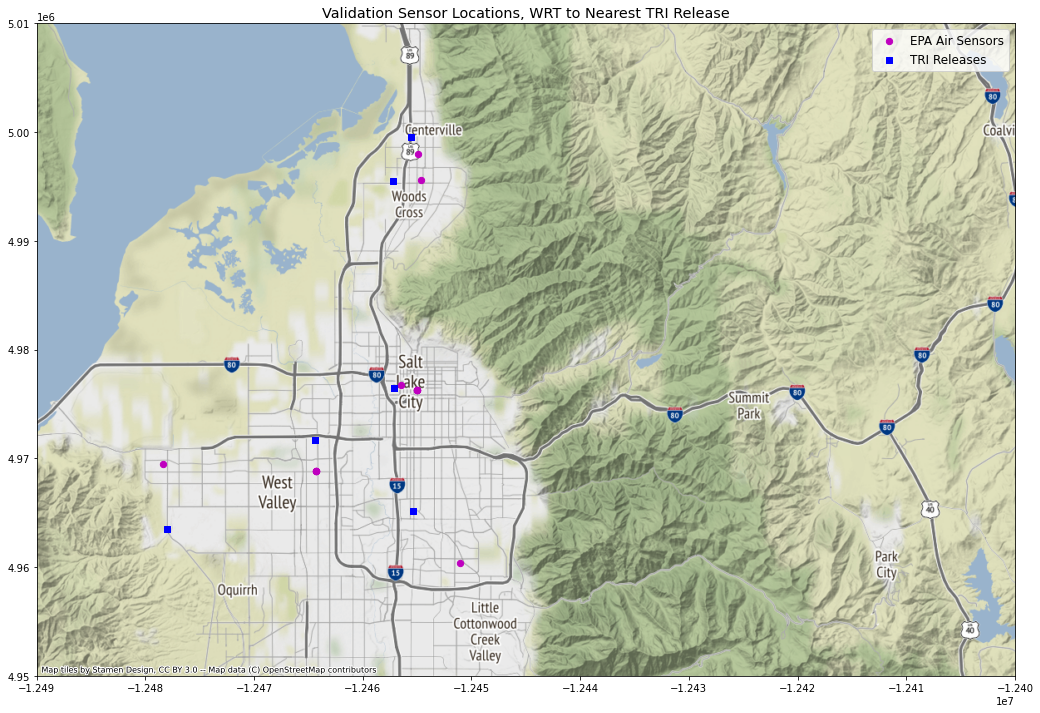

In [11]:
fig,ax = plt.subplots(figsize=(24,12))
plt.rcParams.update({'font.size': 12})
ax.set_xlim(-1.249e7, -1.24e7)
ax.set_ylim(4950000, 5010000)

EPA.plot(ax = ax,color = 'm',markersize = 40,marker='o')
TRI.plot(ax = ax,color = 'b',markersize = 40,marker='s')
ax.legend(['EPA Air Sensors','TRI Releases'])
ax.set_title('Validation Sensor Locations, WRT to Nearest TRI Release')
ctx.add_basemap(ax)
plt.savefig('validation_sensors.png')

1. Note, the data point in the cetner of the plot where there is one TRI release for the two EPA air sensors is not a bug. It is the nearest release to both those sensors.
2. In total, there are 6 sensors with usable proximity levels. 
3. The maximum distance between these points is XX {TO DO}
    - Requires conversion to UTM for 12T then find distance in this unit preserving mapping
4. There are additional sensors which are in the southern portion of the state (x2) part are far from any TRI releases (nearest is over 100 miles).

## Date Mapping and Model Preperation

In [12]:
#Organize the data into daily releases
#fug_par_df_no_dup = chem_date_comb_2(data = fug_par_df_no_dup,
#                            freq = "3H",
#                            release_type = 'fugitive'
#                             )

print('\nProcessing Fugitive Gases')
fug_gas_df_no_dup = chem_date_comb_2(data = fug_gas_df_no_dup,
                            freq = "3H",
                            release_type = 'fugitive'
                             )

#stack_par_df_no_dup = chem_date_comb_2(data = stack_par_df_no_dup,
#                            freq = "3H",
#                            release_type = 'stack'
#                             )

print('\nProcessing Stack Gases')
stack_gas_df_no_dup = chem_date_comb_2(data = stack_gas_df_no_dup,
                            freq = "3H",
                            release_type = 'stack'
                             )


Processing Fugitive Gases
Percentage Complete: 0.00
Percentage Complete: 10.06
Percentage Complete: 20.12
Percentage Complete: 30.18
Percentage Complete: 40.24
Percentage Complete: 50.30
Percentage Complete: 60.36
Percentage Complete: 70.42
Percentage Complete: 80.48
Percentage Complete: 90.54

Processing Stack Gases
Percentage Complete: 0.00
Percentage Complete: 10.89
Percentage Complete: 21.79
Percentage Complete: 32.68
Percentage Complete: 43.57
Percentage Complete: 54.47
Percentage Complete: 65.36
Percentage Complete: 76.25
Percentage Complete: 87.15
Percentage Complete: 98.04


In [13]:
#Double Check the fill
print('Fugitive Particle Releases shape: ' + str(fug_par_df_no_dup.shape))
print('Fugitive Gas Releases shape: ' + str(fug_gas_df_no_dup.shape))
print('Stack Particle Releases shape: ' + str(stack_par_df_no_dup.shape))
print('Stack Gas Releases shape: ' + str(stack_gas_df_no_dup.shape))

#Previous shape before removal of duplicates: 
#Fugitive Particle Releases shape: (569704, 34)
#Fugitive Gas Releases shape: (1536712, 34)
#Stack Particle Releases shape: (432400, 34)
#Stack Gas Releases shape: (1411088, 34)

Fugitive Particle Releases shape: (187, 37)
Fugitive Gas Releases shape: (1452000, 39)
Stack Particle Releases shape: (147, 37)
Stack Gas Releases shape: (1340984, 39)


In [14]:
#Convert all inputs to usable metrics: 
#fug_par_prepped_df = hysplit_input_conversion(fug_par_df_no_dup,0)
fug_gas_prepped_df = hysplit_input_conversion(fug_gas_df_no_dup,0)
#stack_par_prepped_df = hysplit_input_conversion(stack_par_df_no_dup,1)
stack_gas_prepped_df = hysplit_input_conversion(stack_gas_df_no_dup,1)

### Filtering Data for Overlap 

In [15]:
stack_gas_prepped_df.head(3)

date Group  YEAR            TRIFD         FRSID  \
0 1990-01-01     1  1990  84409LVLRN1330W  110009506766   
1 1990-01-01    2B  1990  84302MRTNT9160N  110032607329   
2 1990-01-01    2B  1990  84044HRCLS6800W  110020094351   

                     FACILITYNAME              CITY     COUNTY  ST    ZIP  \
0  LEVOLOR-KIRSCH WINDOW FASHIONS             OGDEN      WEBER  UT  84401   
1   ATK LAUNCH SYSTEMS PROMONTORY        PROMONTORY  BOX ELDER  UT  84307   
2                     HEXCEL CORP  WEST VALLEY CITY  SALT LAKE  UT  84119   

   ...   Phase  StackHeight  StackVelocity StackDiameter StackHeightSource  \
0  ...     Gas          0.6           11.6           0.5          Fac Spec   
1  ...  Liquid          9.1            7.3           0.9          Fac Spec   
2  ...  Liquid         22.5            9.8           1.0          Fac Spec   

   StackVelocitySource StackDiameterSource duplicate_index    Release  \
0             Fac Spec            Fac Spec             105   0.085616   
1             Fac Spec            Fac Spec             286   0.890411   
2             Fac Spec            Fac Spec             419  11.181507   

         HS_loc_input  
0   41.21 -112.01 0.6  
1   41.66 -112.43 9.1  
2  40.65 -112.05 22.5  

[3 rows x 40 columns]

In [16]:
#There are some duplicates in the data
#TODO
fug_gas_prepped_df[fug_gas_prepped_df.duplicated()][['FACILITYNAME','CAS#/COMPOUNDID','LATITUDE','LONGITUDE']].drop_duplicates()

Empty DataFrame
Columns: [FACILITYNAME, CAS#/COMPOUNDID, LATITUDE, LONGITUDE]
Index: []

In [17]:
#Double check the naming scheme won't save over itself
#with this amount of information in the name, there will be no duplicates 
#except for the two facilities which have doubles coming in...but the overwrite should be ok for now. 

fug_gas_prepped_df[['date','FRSID','CAS#/COMPOUNDID','HS_loc_input']].drop_duplicates().shape

#Expect (1452000, 4)

(1452000, 4)

# Speed Testing: 

Trying lots of hyperparameters on a small number of entries. Per each hyperparameter, a test was run on three different chemicals from three different locations. Time was calculated as the average between the three. Each run was on the same chemicals. 

In [38]:
#This will only output the samples for the first 6 hours 
samp = fug_gas_prepped_df[fug_gas_prepped_df['date']<= '01/01/1990 00:00:00']

#This clears any existing directories which begin with HO 
if len(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))!=0:
    for dirs in glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'):
        try:
            shutil.rmtree(dirs)
        except:
            print('unable to delete ' + dirs)

counter = 0 
import timeit
start_time = timeit.default_timer()

for rows in range(samp.shape[0]):
    counter +=1
    release = str(samp.iloc[rows]['Release'])
    fac = str(samp.iloc[rows]['FRSID'])
    chem = str(samp.iloc[rows]['CAS#/COMPOUNDID'])
    lat_lon_height = str(samp.iloc[rows]['HS_loc_input'])
    date = str(samp.iloc[rows]['date'])
    year = date[2:4]
    month = date[5:7]
    day = date[8:10]
    hour = date[11:13]
    date = year+' '+month + ' '+day+' '+hour
    save_name = "HO"+"_"+fac +"_"+ chem  +"_"+ lat_lon_height.replace(' ', '_') +"_"+year+'_'+month+'_'+day+'_'+hour
    print(save_name)
    print(release)
    print(lat_lon_height)
    HYSPLIT_configure(start_model = date, 
                    num_loc = '1', 
                    start_locs = lat_lon_height, 
                    tot_runtime = '48', 
                    mod_top = '10000.0',
                    input_data_grids = '2',
                    grid_1_dir = "C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\",
                    grid_1_name = 'NARR199001',
                    grid_2_dir = 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\',
                    grid_2_name = 'NARR199002',
                    chem_ident = chem,
                    emis_rate = release,
                    emis_hours = '3.0000',
                    samp_interval = '00 3 00',
                    puff_or_part = '3',
                    particle_num = '100',
                    filename = save_name,
                    concplot_a = '1')
    
    if counter==3:
        break
        #print("Total Completed Runs: {0}".format(counter))
elapsed = timeit.default_timer() - start_time    

HO_110009506766_50000_41.21_-112.01_0.00_90_01_01_00
0.08561643835616438
41.21 -112.01 0.00
Script Completed
HO_110011800319_7664939_40.34_-111.74_0.00_90_01_01_00
0.2568493150684932
40.34 -111.74 0.00
Script Completed
HO_110000758378_7664939_41.26_-112.23_0.00_90_01_01_00
0.08561643835616438
41.26 -112.23 0.00
Script Completed


In [39]:
print(elapsed)
print('Time of calculation: {0:1.2f} seconds\n'.format(elapsed/3))

37.87247790000015
Time of calculation: 12.62 seconds



##### This chart is built with the idea that comparison runs are made on Greg's Work PC

| ID | Time (seconds per run)| Particle Number | Run Type | Mod Top | Concplot a | Run Date | Image Name| Notes |
|------|------|------|------|------|------|------|------|------|
|1|5.40| 500|0|500|Concplot|May 27th 2020|Run_1.png|This causes an error for example 2 and 3 which both have a much lower concentration than example 1|
|2|6.71| 500|0|1000|Concplot|May27th 2020|Run_2.png|Same Error as above ^|
|3|15.99|500|0|2000|Concplot|May 27th 2020|Run_3.png|No errors|
|4|14.48|500|0|4000|Concplot|May 27th 2020|Run_4.png|Error with plot 3, no concentration data|
|5|8.74|500|0|100|Concplot|May 27th 2020|Run_5.png|Errors within all plots. Still trying to figure out what the top of the model is relative to the grid defined model layer|
|6|5.71|100|0|2000|Concplot|May 27th 2020|Run_6.png|Error on plot 2, hour 42|
|7|10.17|1000|0|2000|Concplot|May 27th 2020|Run_7.png|Error on plot 2, hour 42|
|8|19.38|500|0|10000|Concplot|June 1st 2020|Run_8.png|Run with standard setting for modtop (10,000). Recieved one error on plot 2 at time step 3. Can see the missing data in plotting legend|
|9|13.08|1000|0|10000|Concplot|June 1st 2020|Run_9.png|Run with standard setting for modtop (10,000). Recieved one error on 110009506766 for timestep hours after 6 indicating no concentration information was relayed. |
|10|17.50|2000|0|10000|Concplot|June 1st 2020|Run_10.png|Run with standard setting for modtop (10,000). No Errors. |
|11|26.04|4000|0|10000|Concplot|June 1st 2020|Run_11.png|Run with standard setting for modtop (10,000). No Errors. |
|12|97.32|100|1|10000|Concplot|June 1st 2020|Run_12.png|Run with standard setting for modtop (10,000). No Errors.|
|13|80.95|100|1|10000|Concplot|June 1st 2020|Run_13.png|Run with standard setting for modtop (10,000). Same as above.|
|14|49.55|100|3|10000|Concplot|June 1st 2020|Run_14.png|Run with standard setting for modtop (10,000). Changed to different puff config (3)|
|15|7.74|100|3|10000|Concplot|June 1st 2020|Run_15.png|Reducing the size of the grid to 0.5 x 0.5 degrees, mutliple errors. Graphs look very rough.|
|16|40.72|50|3|10000|Concplot|June 1st 2020|Run_16.png|Grid size back to 0.05, errors on 110012347193 on last run|
|17|34.57|20|3|10000|Concplot|June 1st 2020|Run_17.png|Shrinking number of puffs, hybrid approach|
|18|38.42|10|3|10000|Concplot|June 1st 2020|Run_18.png|Shrinking number of puffs, hybrid approach, multiple file errors|
|19|36.68|2|3|10000|Concplot|June 1st 2020|Run_19.png|Shrinking number of puffs, multiple files still showing error|
|20|13.78|2|4|10000|Concplot|June 1st 2020|Run_20.png|Trying different modeling type, no reported errors|
|21|12.28|2|4|10000|Concplot|June 1st 2020|Run_21.png|No visual difference|
|22|24.00|100|4|10000|Concplot|June 1st 2020|Run_22.png|Shrinking the plotting area, so as to only include Utah|
|23|6.66|20|4|10000|Concplot|June 1st 2020|Run_23.png|Retrying the smaller puff number with new boundary, no errors, visually identical to the previous entry|
|24|15.29|100|3|10000|Concplot|June 1st 2020|Run_24.png|definite visual differences. Showcases difference between gaussian (3) and top hat (4) with particle vertical distribution|
|25|11.96|100|2|10000|Concplot|June 1st 2020|Run_25.png|Changing the puff mode to explore the best parameters for speed. Puff number should not matter. Results do not look accurate|
|26|17.06|100|0|10000|Concplot|June 1st 2020|Run_26.png|Changing puff mode (1), still appears very general. Double 
|27|9.74|2500|0|10000|Concplot|June 1st 2020|Run_27.png|Changing back to particle mode, no model errors|
|28|6.74|1000|0|10000|Concplot|June 1st 2020|Run_28.png|Decreasing number of particles, errors. This appears to be too few particles|
|29|13.44|5000|0|10000|Concplot|June 1st 2020|Run_29.png|Increasing number of particles, error encountered in first plot: 110000469476 (higher conc)|
|30|24.51|5000|0|10000|Concplot|June 1st 2020|Run_30.png|Increasing number of particles, no errors encountered. This appears to be getting to be too many particles)|
|31|16.34|100|3|10000|Concplot|June 22nd 2020|Run_31.png|Testing with new centering parameters. Things were still going beyond Utah because the center of the grid was adjusted to the center of the release per each run.|


Could the errors be coming from not having enough particles for the desired concentration?
- At 8, implementing Kevin Perry Recommendations
- At 12,trying puff simulations
- At 24, trying other puff simulation modes (top hat and vertical puff) and 3 (gaussian horizontal and top hat vertical)
- At 26, retry particle simulation using reduced dimension size. 

**CONCLUSION**
<br> Using this very rough first pass, it seems that two parameters strike as the best options. I plan to run these on longer simulations to see if they continue to perform well. 
1. Run 27 parameters (particle simulation)- increased accuracy
2. Run 22 parameters (top hat and particle vertical) - fastest speed

Other Conclusions:
- KP states the top of the model for concentration models is a reflective boundary. Thus, it must be high enough to not affect calculations. Going to set the parameter much higher, hopefully this will eliminate the errors. 
- For puff simulations, we need to alter several additional parameters including:
    1. Grid Cell Size: Kept at 0.05 
    2. Particles Released per cycle: Altered while watching the output. 


In [40]:
#Grab all the shapefiles and append to a list
#Create a directory for the run: 
path = ".\\speed_testing\\Run_31\\"
if os.path.isfile(path)==False:
    os.mkdir(path)

#plot the location
for idx,dirs in enumerate(sorted(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))):
    directory = dirs.replace('\\','\\\\') + '\\\\'
    print(directory)
    
    ls =[]
    for files in sorted(os.listdir(directory),reverse=False):
        data = gpd.read_file(directory+files)
        try:
            data = data.to_crs({'init': 'epsg:3857'})
            data['CONC'] = data['CONC'].astype(float)
            ls.append(data)
        except:
            print("error on file: " +files)

    #HYSPLIT Data 
    gdf = gpd.GeoDataFrame(pd.concat(ls,
                            ignore_index=True),crs=data.crs)
    gdf=gdf.sort_values('CONC')

    #Plot the figures
    fig,ax = plt.subplots(figsize=(24,12))
    plt.rcParams.update({'font.size': 12})

    #Plot the plume
    gdf.plot(cmap='YlOrRd',
             ax=ax,
             column='CONC',
             legend=True,
             alpha=0.8,
            legend_kwds={'label': "Pollutant Concentration log10(plbs/m^3)"})


    #Add some Parameters and labels
    ax.set_title("01.01.90 00:00:00 - {1} - 48 hr track -ID 30_{0}".format(str(idx+1),directory[46:58]))
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,# ticks along the top edge are off
        left=False,
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off

    #Add the background mappings
    ctx.add_basemap(ax)

    #SaveFig
    plt.savefig(path + 'Run_31_{0}.png'.format(str(idx+1)))
    plt.close()

C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000758378_7664939_41.26_-112.23_0.00_90_01_01_00\\
C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110009506766_50000_41.21_-112.01_0.00_90_01_01_00\\
C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110011800319_7664939_40.34_-111.74_0.00_90_01_01_00\\


# Robustness Testing

From the last test, two hyperparameter sets stand out as being the fasest both averaging times of <7 seconds. Here we are going to make sure those calculations are robust by running both hyperparameters on a much larger subset of data (100 runs). 

In [ ]:
#Look at "more" vs "less" representative output data. 

#TODO

In [ ]:
#This will only output the samples for the first 6 hours 
samp = fug_gas_prepped_df[fug_gas_prepped_df['date']<= '01/20/1990 06:00:00']

#This clears any existing directories which begin with HO 
if len(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))!=0:
    for dirs in glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'):
        try:
            shutil.rmtree(dirs)
        except:
            print('unable to delete ' + dirs)

counter = 0 
import timeit
start_time = timeit.default_timer()

for rows in range(samp.shape[0]):
    counter +=1
    release = str(samp.iloc[rows]['Release'])
    fac = str(samp.iloc[rows]['FRSID'])
    chem = str(samp.iloc[rows]['CAS#/COMPOUNDID'])
    lat_lon_height = str(samp.iloc[rows]['HS_loc_input'])
    date = str(samp.iloc[rows]['date'])
    year = date[2:4]
    month = date[5:7]
    day = date[8:10]
    hour = date[11:13]
    date = year+' '+month + ' '+day+' '+hour
    save_name = "HO"+"_"+fac +"_"+ chem  +"_"+ lat_lon_height.replace(' ', '_') +"_"+year+'_'+month+'_'+day+'_'+hour
    print(save_name)
    print(release)
    print(lat_lon_height)
    HYSPLIT_configure(start_model = date, 
                    num_loc = '1', 
                    start_locs = lat_lon_height, 
                    tot_runtime = '48', 
                    mod_top = '10000.0',
                    input_data_grids = '2',
                    grid_1_dir = "C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\",
                    grid_1_name = 'NARR199001',
                    grid_2_dir = 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\',
                    grid_2_name = 'NARR199002',
                    chem_ident = chem,
                    emis_rate = release,
                    emis_hours = '3.0000',
                    samp_interval = '00 3 00',
                    puff_or_part = '3',
                    particle_num = '100',
                    filename = save_name,
                    concplot_a = '1')
    
    if counter==100:
        break
        #print("Total Completed Runs: {0}".format(counter))
elapsed = timeit.default_timer() - start_time    

In [ ]:
print('100-Examples Average time: {0:1.2f} seconds\n'.format(elapsed/100))

In [ ]:
#Did all import correctly?
#Create a directory for the run: 
path = ".\\robust_testing\\puff_100\\"
if os.path.isfile(path)==False:
    os.mkdir(path)
    
#plot the location
for idx,dirs in enumerate(sorted(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))):
    directory = dirs.replace('\\','\\\\') + '\\\\'
    
    ls =[]
    for files in sorted(os.listdir(directory),reverse=False):
        data = gpd.read_file(directory+files)
        try:
            data = data.to_crs({'init': 'epsg:3857'})
            data['CONC'] = data['CONC'].astype(float)
            ls.append(data)
        except:
            print("error on file: " +directory + files)
    
    if idx%10==0:     
        #HYSPLIT Data 
        gdf = gpd.GeoDataFrame(pd.concat(ls,
                                ignore_index=True),crs=data.crs)
        gdf=gdf.sort_values('CONC')

        #Plot the figures
        fig,ax = plt.subplots(figsize=(24,12))
        plt.rcParams.update({'font.size': 12})

        #Plot the plume
        gdf.plot(cmap='YlOrRd',
                 ax=ax,
                 column='CONC',
                 legend=True,
                 alpha=0.8,
                legend_kwds={'label': "Pollutant Concentration log10(plbs/m^3)"})


        #Add some Parameters and labels
        ax.set_title("01.01.90 00:00:00 - {1} - 48 hr track -ID 30_{0}".format(str(idx+1),directory[46:58]))
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,# ticks along the top edge are off
            left=False,
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off

        #Add the background mappings
        ctx.add_basemap(ax)

        #SaveFig
        plt.savefig(path + 'Run_{0}.png'.format(str(idx+1)))
        plt.close()

### Particle Method 2500 

In [ ]:
#This will only output the samples for the first 6 hours 
samp = fug_gas_prepped_df[fug_gas_prepped_df['date']<= '01/20/1990 00:00:00']

#This clears any existing directories which begin with HO 
if len(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))!=0:
    for dirs in glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'):
        try:
            shutil.rmtree(dirs)
        except:
            print('unable to delete ' + dirs)

counter = 0 
import timeit
start_time = timeit.default_timer()

for rows in range(samp.shape[0]):
    counter +=1
    release = str(samp.iloc[rows]['Release'])
    fac = str(samp.iloc[rows]['FRSID'])
    chem = str(samp.iloc[rows]['CAS#/COMPOUNDID'])
    lat_lon_height = str(samp.iloc[rows]['HS_loc_input'])
    date = str(samp.iloc[rows]['date'])
    year = date[2:4]
    month = date[5:7]
    day = date[8:10]
    hour = date[11:13]
    date = year+' '+month + ' '+day+' '+hour
    save_name = "HO"+"_"+fac +"_"+ chem  +"_"+ lat_lon_height.replace(' ', '_') +"_"+year+'_'+month+'_'+day+'_'+hour
    print(save_name)
    print(release)
    print(lat_lon_height)
    HYSPLIT_configure(start_model = date, 
                    num_loc = '1', 
                    start_locs = lat_lon_height, 
                    tot_runtime = '48', 
                    mod_top = '10000.0',
                    input_data_grids = '2',
                    grid_1_dir = "C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\",
                    grid_1_name = 'NARR199001',
                    grid_2_dir = 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\NARR_Weather_Data\\',
                    grid_2_name = 'NARR199002',
                    chem_ident = chem,
                    emis_rate = release,
                    emis_hours = '3.0000',
                    samp_interval = '00 3 00',
                    puff_or_part = '0',
                    particle_num = '2500',
                    filename = save_name,
                    concplot_a = '1')
    
    if counter==100:
        break
        #print("Total Completed Runs: {0}".format(counter))
elapsed = timeit.default_timer() - start_time    

In [ ]:
print('100-Examples Average time: {0:1.2f} seconds\n'.format(elapsed/100))

In [ ]:
#Did all import correctly?
#Create a directory for the run: 
path = ".\\robust_testing\\part_2500\\"
if os.path.isfile(path)==False:
    os.mkdir(path)
    
count = 0    
#plot the location
for idx,dirs in enumerate(sorted(glob.glob('C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_*'))):
    directory = dirs.replace('\\','\\\\') + '\\\\'
    
    ls =[]
    for files in sorted(os.listdir(directory),reverse=False):
        data = gpd.read_file(directory+files)
        try:
            data = data.to_crs({'init': 'epsg:3857'})
            data['CONC'] = data['CONC'].astype(float)
            ls.append(data)
        except:
            count +=1
            print("error on file: " +directory + files)
    
    if idx%10==0:     
        #HYSPLIT Data 
        gdf = gpd.GeoDataFrame(pd.concat(ls,
                                ignore_index=True),crs=data.crs)
        gdf=gdf.sort_values('CONC')

        #Plot the figures
        fig,ax = plt.subplots(figsize=(24,12))
        plt.rcParams.update({'font.size': 12})

        #Plot the plume
        gdf.plot(cmap='YlOrRd',
                 ax=ax,
                 column='CONC',
                 legend=True,
                 alpha=0.8,
                legend_kwds={'label': "Pollutant Concentration log10(plbs/m^3)"})


        #Add some Parameters and labels
        ax.set_title("01.01.90 00:00:00 - {1} - 48 hr track -ID 30_{0}".format(str(idx+1),directory[46:58]))
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,# ticks along the top edge are off
            left=False,
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off

        #Add the background mappings
        ctx.add_basemap(ax)

        #SaveFig
        plt.savefig(path + 'Run_{0}.png'.format(str(idx+1)))
        plt.close()

### Results

| Method | Time (seconds per run)| Errors | Notes |
|------|------|------|------|
| Particles (2500) | 13.88 | Yes - 25 in total | As expected the particle simulation is much more precise than the puff. On average it takes almost double the time though! |
| Puff (100) | 7.87 | Yes - 27 in total | see above | 

## Spatial Concatenation

1. Going to try using the overlay command as the spatial join did not work.

Text(0.5, 0.98, 'Release after 3 and 6 hours (with log transformation)')

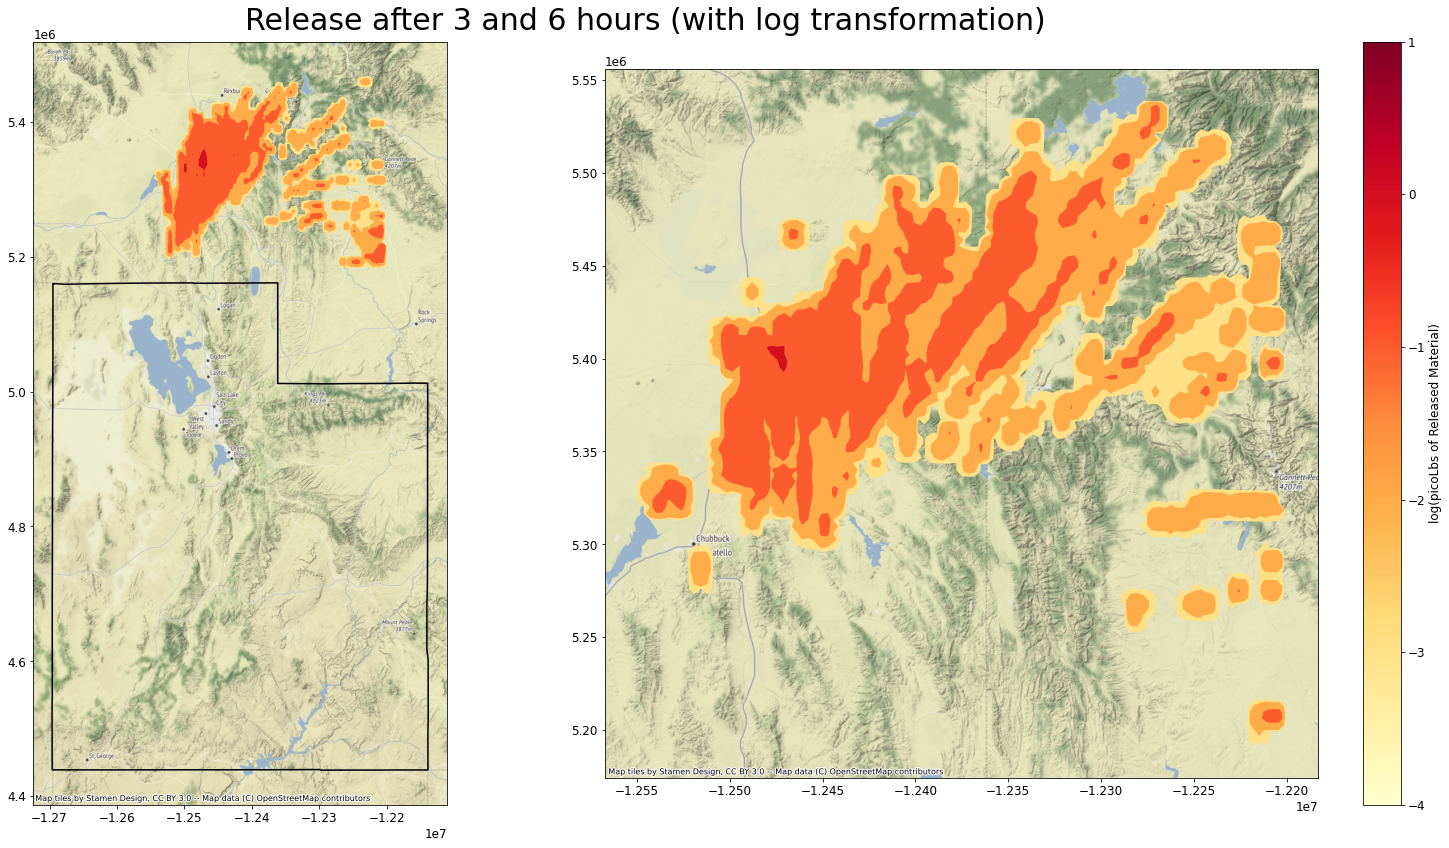

In [205]:
#PATH = 'C:\\Users\\u0890227\\Desktop\\TRI_HYSPLIT\\HO_110000468921_71432_40.84_-111.92_0.00_90_01_01_00\\'
PATH = 'data/HO_110032607329_123911_41.66_-112.43_0.00_90_01_01_00/'

#Plot the Boundary of the State
state =fiona.open('/home/boogie2/Data_Science/Purp_Air_Analysis/Utah.gdb')

# Build the GeoDataFrame from Fiona Collection
state_gdf = gpd.GeoDataFrame.from_features([feature for feature in state], crs=state.crs)
# Get the order of the fields in the Fiona Collection; add geometry to the end
columns = list(state.meta["schema"]["properties"]) + ["geometry"]
# Re-order columns in the correct order
state_gdf = state_gdf[columns]
#Recast the mapping environment
state_gdf = state_gdf.to_crs('EPSG:3857')


#Load the data
hour3 = gpd.read_file(PATH + 'hour_after_start_12')
hour3 = gpd.GeoDataFrame(hour3,crs=hour3.crs)
hour3['CONC']=hour3['CONC'].astype(float)
hour3 = hour3.to_crs({'init': 'epsg:3857'})

hour6 =  gpd.read_file(PATH + 'hour_after_start_15')
hour6 = gpd.GeoDataFrame(hour6,crs=hour6.crs)
hour6['CONC']=hour6['CONC'].astype(float)
hour6 = hour6.to_crs({'init': 'epsg:3857'})

#Plot the plumes
fig,ax = plt.subplots(1,2,figsize=(24,12))
state_gdf[state_gdf['STATE']=='Utah'].boundary.plot(ax=ax[0],color='k')
hour3.plot(cmap='YlOrRd',
            ax=ax[0],
            column='CONC',vmin=-4,vmax=1)
ctx.add_basemap(ax[0])

hour6.plot(cmap='YlOrRd',
            ax=ax[1],
            column='CONC',vmin=-4,vmax=1,
            legend = True,
            legend_kwds={'label': "log(picoLbs of Released Material)"})
ctx.add_basemap(ax[1])




fig.tight_layout()
fig.subplots_adjust(top=0.94)

fig.suptitle('Release after 3 and 6 hours (with log transformation)',size=30)
#plt.savefig('sep_releases.png')

In [195]:
#Load a grid shapefile (built in ARCGIS by Heidi)
UTFish=gpd.read_file("./UTFishLatLon2")

#Change the coordinate system to match first
UTFish = UTFish.to_crs({'init': 'epsg:3857'})

#Merge the data onto a grid
hour_3_grid=gpd.sjoin(UTFish, hour3, how="left", op="intersects")
hour_6_grid = gpd.sjoin(UTFish, hour6, how="left", op="intersects")

#Weirdly the shapes do not match. Appears to be caused by some aliasing on overlapping squares (both are shown)
#Duplicates are causing multiple values (multiple shape layers. I will keep the max)
hour_3_grid=hour_3_grid.sort_values('CONC', ascending=False).drop_duplicates('OID_').sort_index()
hour_6_grid=hour_6_grid.sort_values('CONC', ascending=False).drop_duplicates('OID_').sort_index()

In [196]:
#Remove the log10 transformation for addition 
hour_3_grid['non_log_CONC'] = np.power(10,hour_3_grid['CONC'])
hour_6_grid['non_log_CONC'] = np.power(10,hour_6_grid['CONC'])

In [197]:
#So I will need to concatenate than sum based upon a groupby for geometery
test =  pd.concat([hour_3_grid,hour_6_grid])
test = test.groupby('OID_')['non_log_CONC'].sum()
temp = UTFish
temp['non_log_CONC'] = test.values

#Need to convert back to log for plotting 
#First convert all 0's to nan
temp['non_log_CONC']=temp['non_log_CONC'].replace(0, np.nan)
temp['log_conc'] = np.log10(temp['non_log_CONC'])

In [202]:
temp['log_conc'].notna().sum()

0

In [198]:
fig,ax = plt.subplots(1,1,figsize=(24,12))
temp[temp['non_log_CONC'].notna()].plot(cmap='YlOrRd',
                                    ax=ax,
                                    column='non_log_CONC',
                                    legend=True,
                                    legend_kwds={'label': "picoLbs of Released Material"}
                                  )
ctx.add_basemap(ax)
ax.set_title('Tiled Release')
#plt.savefig('tiled_release.png')

HTTPError: Tile URL resulted in a 404 error. Double-check your tile url:
https://stamen-tiles-a.a.ssl.fastly.net/terrain/27/67108864/67108860.png

Text(0.5, 1.0, 'Tiled Release (log transformed)')

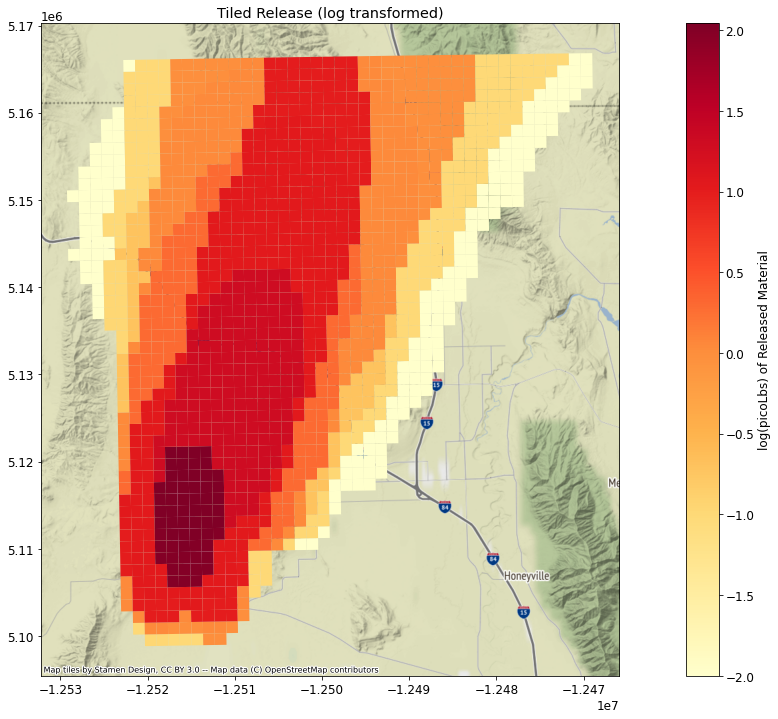

In [27]:
fig,ax = plt.subplots(1,1,figsize=(24,12))
temp[temp['log_conc'].notna()].plot(cmap='YlOrRd',
                                    ax=ax,
                                    column='log_conc',
                                    legend=True,
                                    legend_kwds={'label': "log(picoLbs) of Released Material"}
                                  )
ctx.add_basemap(ax)
ax.set_title('Tiled Release (log transformed)')
#plt.savefig('tiled_release_log.png')

# Harmonizing Concatentation

In [40]:
#What kind of test data do we have here: 
folder_list=sorted(glob.glob('./data/HO_*'))

#Split into strings for easy access to parts
folder_split_name = [i.split('_') for i in folder_list]

#In total there are 4 seperate releases. 1 Only has data from the first simulation. All others have data for two simulations i
#Thus I expect there to be 17 entries within the labeled dictionary

In [86]:
def datespan(startDate, delta,tot_time):
    """Yields dates from start date to the start date + tot_time at rate of change delta. 
    ===
    Inputs: 
    startDate: datetime object where the returns should start
    delta: datetime object for the timesteps taken
    tot_time: total number of hours to run outputs after starttime
    """
    currentDate = startDate 
    while currentDate < startDate+datetime.timedelta(hours=tot_time):
        yield currentDate
        currentDate += delta

def grid_creator(grid_dict,blank_grid,tri_folder):
    """This function takes a folder of TRI releases and outputs a dictionary with dates and corresponding shapefiles. 
    
    ===
    Inputs: 
    1. grid_dict - a dictionary (can be empty) to contain geodataframes (values) held by date (keys).
    2. blank_grid - UTFish - a shapefile of 1kmx1km squares of Utah, created by Dr. Hanson in ARCgis
    3. tri_folder - a folder which contains multiple TRI release simulations from HYSPLIT, where the title has the year month date and hour as the last four entries, seperated by _. 

    Outputs: 
    1. grid_dict - a dictionary containing geodataframes covering all dates within the model folders. 
    """
    #Split the folder name into its respective pieces for easy indexing. Assumes _ spacing
    tri_folder = [i.split('_') for i in tri_folder]

    #Shapefiles dict names will contain the year_month_day_hour --> This is what the spatial join will be
    for entries in tri_folder:
        #Each modeling entry has the start date. Need dates for + 48hrs beyond at timesteps of 3 hours
        ymdh= entries[-4] +'_'+ entries[-3] +'_'+ entries[-2] +'_'+entries[-1]
        ymdh=datetime.datetime.strptime(ymdh,'%y_%m_%d_%H')

        #Loop through all timesteps and create new empty entries if non-existent (set for 48 simulations with a timestep of 3 hours)
        for timesteps in datespan(ymdh,delta=datetime.timedelta(hours=3),tot_time = 48):
            if timesteps not in grid_dict.keys():
                grid_dict[timesteps] = blank_grid

    return grid_dict

In [180]:
#Step 1:Prepare Inputs: 
UTFish=gpd.read_file("./UTFishLatLon2")
UTFish = UTFish.to_crs({'init': 'epsg:3857'})
utah_grid_dict = {}

#Run Grid Prep
utah_grid_dict = grid_creator(utah_grid_dict,UTFish,folder_list)
print(len(test))

#Good: We expect 17 

17


## So unfortunately it appears that the centering did not work. The model is going outside of the desired bounding box. Need to go reset the center on the modeling runs

In [152]:
#Beta Test: Data Merging onto the utah grid, try for just 2 entries
counter = 0

for entries in folder_list[:2]:
    temp_dict={}

    for path in sorted(glob.glob(entries +'/hour*',recursive=True)):
        #This loop goes through all paths within a model pathway (hour3-48)

        #Extract information from model file
        #This is a non-robust solution for where the characters lie within the string. 
        temp = path.split('_')
        FRS_ID = temp[1]
        CAS = temp[2]
        hour_after = datetime.timedelta(hours = int(temp[-1]))
        ymdh= temp[6] +'_'+ temp[7] +'_'+ temp[8] +'_'+temp[9].split('/')[0]
        ymdh=datetime.datetime.strptime(ymdh,'%y_%m_%d_%H')
        ymdh =ymdh + hour_after

        #Load into a geodataframe
        data = gpd.read_file(path)
        data = gpd.GeoDataFrame(data,crs=data.crs)
        data['CONC']=data['CONC'].astype(float)
        data['CAS'] = CAS
        data['FRS_ID']=FRS_ID
        data = data.to_crs({'init': 'epsg:3857'})

        #Merge to grid
        tmp = gpd.sjoin(UTFish,data, how='left',op='intersects')

        #Where shapes overlap, taking the max
        data=data.sort_values('CONC', ascending=False).drop_duplicates('OID_').sort_index()

        #Remove the log transformation in order to perform spatial sum
        data['non_log_CONC'] = np.power(10,data['CONC'])

        #Save Entries to a temporary dictionary
        temp_dict[ymdh] = data

        print(hour_after)
        print(path)
        counter+=1

        if counter == 2:
            break

    #Once the inner loop has completed, need to find the key overlap (which pieces of empty grid need to be updated)
    intersect = []
    for item in temp_dict.keys():
        if item in utah_grid_dict.keys():
            intersect.append(item)

    #
    for dt_keys in intersect:
        temp = pd.concat([temp_dict[dt_keys],utah_grid_dict[dt_keys]])
        temp = temp.groupby('OID_')['non_log_CONC'].sum()
        utah_grid_dict[dt_keys]['non_log_CONC'] = temp.values

        utah_grid_dict[dt_keys]['non_log_CONC'] =utah_grid_dict[dt_keys]['non_log_CONC'] .replace(0, np.nan)
        utah_grid_dict[dt_keys]['log_conc'] = np.log10(utah_grid_dict[dt_keys]['non_log_CONC'] )   


    break

12:00:00
./data/HO_110032607329_123911_41.66_-112.43_0.00_90_01_01_00/hour_after_start_12
15:00:00
./data/HO_110032607329_123911_41.66_-112.43_0.00_90_01_01_00/hour_after_start_15
